# Parallel Experiments in Eight Schools

In this notebook we will go through the "Eight Schools" example from Gelman et al., Bayesian Data Analysis, Chapter 5.5.

First, we import `pystan` and ensure that everything is working properly.

In [1]:
import pystan
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Setup and data

Eight schools have tried out a new special coaching program which can help students prep for a standardized college admissions exam. This standardized exam is designed to be resistant to short-term cramming (instead aiming to capture knowledge acquired over the duration of primary and secondary education). However, each of these schools has administered a coaching program and has estimated its effect on the student scores by use of a randomized trial. For each school, we have an estimated mean "treatment effect", i.e. the increase or decrease in the student scores, and a standard error.

The data is as follows:

| School | A | B | C | D | E | F | G | H |
| --: | --- | --- | --- | --- | --- | --- | --- | --- |
| Estimated treatment effect, $y_j$ | 28 | 8 | -3 | 7 | -1 | 1 | 18 | 12 |
| Standard error of effect estimate, $\sigma_j$ | 15 | 10 | 16 | 11 | 9 | 11 | 10 | 18 |

* **Q** Do we think think these coaching programs are successful, in general?
* **Q** Are they more successful in some schools than others?

The first thing we should always to is try to visualize the data.

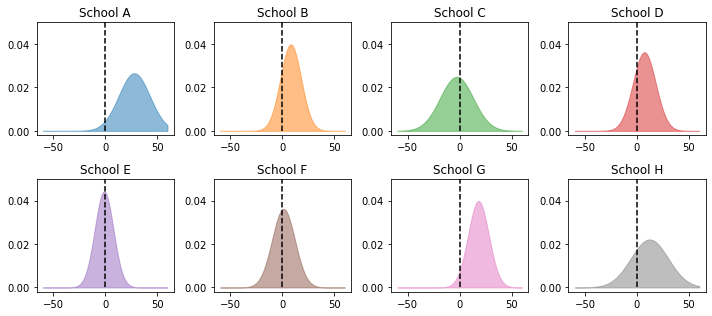

In [2]:
# Define the arrays of the data
mean = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])
schools = 'ABCDEFGH'

# Plot one normal distribution for each school
domain = np.linspace(-60, 60, 200);
normpdf = lambda x, m, s: np.exp(-0.5/(s**2)*(x - m)**2) / (s*np.sqrt(2*np.pi))
plt.figure(figsize=(10, 4.5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot([0,0], [0, 0.05], 'k--');
    plt.fill_between(domain, 0, normpdf(domain, mean[i], sigma[i]), color='C%d' % i, alpha=0.5);
    plt.title("School "+schools[i]);
    plt.ylim(-0.002, 0.05);
plt.tight_layout();

## How much does the test help improve scores?

While many of the schools show a positive treatment effect, in most of them the overall effect size is small relative to the standard error. In other words, taking any particular school independently, the result is not statistically significant. On the other hand, most of the schools did show some positive improvement, so maybe by considering all the schools together we could estimate whether or not these coaching programs are effective overall.

### Two viewpoints:

* Every school is different — to estimate the effect size *in school A*, we just need to look at the mean difference in test scores.

From this perspective, we are viewing 8 completely different experiments, each of which estimates a completely different parameter: *How well does coaching work in a particular school*.

This model can be thought of as estimating eight different parameters $\theta_j$, in a model where

$$y_j | \theta_j, \sigma_j \sim \mathcal{N}(y_j | \theta_j, \sigma_j^2)$$

for each $j = 1,\dots, 8$.

* … but, every school is using a similar coaching program! Keep in mind this standardized test was specifically designed to be "resistant" to coaching. To estimate the effect size of the coaching programs in general, we need to consider how well this program performs in all of the schools.

From this perspective, we have eight independent estimates of a single parameter: *How well does a coaching program work?".

This model, with just one $\theta$, can be written as

$$y_j | \theta, \sigma_j \sim \mathcal{N}(y_j | \theta, \sigma_j^2).$$


* **Q** Which model should we use? Why?

Here is a plot of the combined effect across all schools. (See Gelman et al p.120 for computations.)

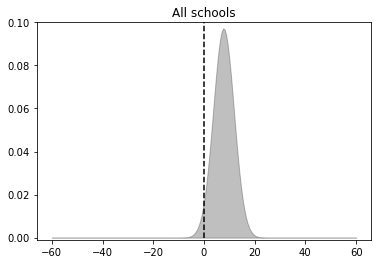

In [3]:
combined_mean = 7.7
combined_std = 4.1

plt.plot([0,0], [0, 0.1], 'k--');
plt.fill_between(domain, 0, normpdf(domain, combined_mean, combined_std), color='k', alpha=0.25);
plt.title("All schools");
plt.ylim(-0.001, 0.1);

## We can also estimate this using Stan.

A Stan model is broken down into *blocks*.

The first block is the `data` block. This data block defines values which must be specified when we run our sampler, and are then fixed:

```
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
```

These values have types `int`, and `real`, and can have constraints (e.g. `lower=0`) and can also be vector-value (e.g. `y[J]`). Lines end in semicolons; braces wrap blocks; and `//` defines a comment.

The second important block is the `parameters` block. This block provides declarations of *what we are going to sample*. Any variables declared here will be sampled by the MCMC algorithm:

```
parameters {
    real theta;
}
```

Next we have a `model` block. This block is used to define the actual generative model code, and defines a joint probability distribution. This uses variables declared in other blocks. The `~` operation performs sampling:

```
model {
    y ~ normal(theta, sigma);
}
```

The final block we have here is a `generated quantities` block. This block can be used to compute any quantities which are a function of the parameters. This can be useful for making predictions. (Note that it's also possible to compute generated quantities later, in external software, using the samples.) Here, we compute a boolean value indicating whether or not $\theta$ is greater than zero.

```
generated quantities {
    int<lower=0,upper=1> is_positive;
    
    is_positive = theta > 0;
}
```

The expected value of `is_positive` will correspond to $\Pr(\theta > 0)$.

There are other types of blocks as well, which we will get to later. 

Once we have defined our model (in python, it is a text string) we then have to compile it. Unfortunately, this can take around a minute to run, at least on my laptop. Fortunately, most errors are compile-time errors, so if your model does compile, it will likely work, which keeps debugging loops fast even if compilation is slow.

In [4]:
pooled_model_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real theta;
}
model {
    y ~ normal(theta, sigma);
}
generated quantities {
    int<lower=0,upper=1> is_positive;
    
    is_positive = theta > 0;
}
"""

pooled_model = pystan.StanModel(model_code=pooled_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a866080a79546c5443dd75f0c63cd5d6 NOW.
/Users/brooks/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/p5/l7hjjt052zzf95mb4qqnb6nw0000gn/T/tmpkf0mqs1s/stanfit4anon_model_a866080a79546c5443dd75f0c63cd5d6_1487162386135362264.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We now run four parallel MCMC chains, for 1000 iterations each. We will compute some statistics and plot a density estimate of theta (and a trace plot) for each of the chains.

Inference for Stan model: anon_model_a866080a79546c5443dd75f0c63cd5d6.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta         7.57    0.13   3.95  -0.67   5.07   7.63  10.17  15.16    901    1.0
is_positive   0.96  5.4e-3   0.19    0.0    1.0    1.0    1.0    1.0   1171    1.0
lp__         -2.82    0.02   0.67  -4.77  -2.96  -2.55   -2.4  -2.35    929    1.0

Samples were drawn using NUTS at Sun Nov 29 21:33:49 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


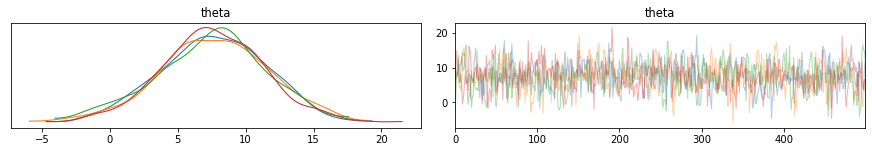

In [5]:
schools_data = {'J': 8,
                'y': mean,
                'sigma': sigma}

pooled_fit = pooled_model.sampling(data=schools_data, iter=1000, chains=4)
print(pooled_fit)

az.plot_trace(pooled_fit, var_names=["theta"]);

We can directly index into our `fit` object to look at the samples.

Estimated Pr(theta > 0) = 0.9645


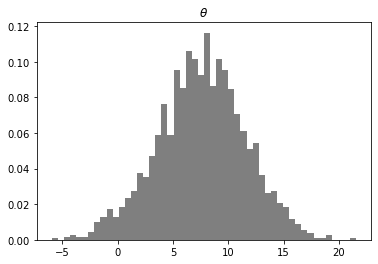

In [6]:
print("Estimated Pr(theta > 0) = %0.4f" % pooled_fit['is_positive'].mean())
plt.hist(pooled_fit['theta'], density=True, bins=50, color='k', alpha=0.5);
plt.title("$\\theta$");

## Separate schools model

For the separate model, we would make only one tiny adjustment to our model code.

In the `parameters` block, we replace

```real theta;```

with

```real theta[J];```

This means that `theta[J]` is now a vector of length $J$, instead of a scalar.

We could run this model in Stan as well, though it isn't very interesting, but let's do it anyway for practice and look at the trace plots.

Here, we consider a different statistic in `generated quantities`: an indicator variable for whether the effect in School A is greater than that in School C.

In [7]:
separate_model_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real theta[J];
}
model {
    y ~ normal(theta, sigma);
}
generated quantities {
    int<lower=0,upper=1> A_gt_C;
    
    A_gt_C = theta[1] > theta[3];
}
"""

separate_model = pystan.StanModel(model_code=separate_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2e8c5d9d718c0e9f46d901389830420d NOW.
/Users/brooks/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/p5/l7hjjt052zzf95mb4qqnb6nw0000gn/T/tmpqx9es_41/stanfit4anon_model_2e8c5d9d718c0e9f46d901389830420d_6518242784189352040.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [8]:
separate_fit = separate_model.sampling(data=schools_data, iter=1000, chains=4)
print(separate_fit)

Inference for Stan model: anon_model_2e8c5d9d718c0e9f46d901389830420d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]  27.46    0.26  15.24  -2.85  17.07  27.28   37.8  56.24   3529    1.0
theta[2]   7.82    0.18   9.96 -11.72   1.16   7.64  14.48  27.38   3195    1.0
theta[3]  -2.81    0.26  15.22  -32.3 -13.34  -2.44   7.74  26.04   3354    1.0
theta[4]   6.85    0.19  10.99 -13.61  -0.56   6.73  14.49  28.06   3252    1.0
theta[5]   -1.1    0.16   8.71 -17.27  -7.16  -1.26   4.64   16.4   2951    1.0
theta[6]   1.04     0.2  10.71 -20.55  -6.07   1.12   8.35  21.11   2973    1.0
theta[7]  18.34     0.2   9.93  -1.44  11.61  18.15   25.2   37.2   2565    1.0
theta[8]  12.28    0.29   17.7 -22.68   0.64  12.46  24.09   47.2   3751    1.0
A_gt_C     0.92  6.5e-3   0.26    0.0    1.0    1.0    1.0    1.0   1634    1.0
lp__      -3.

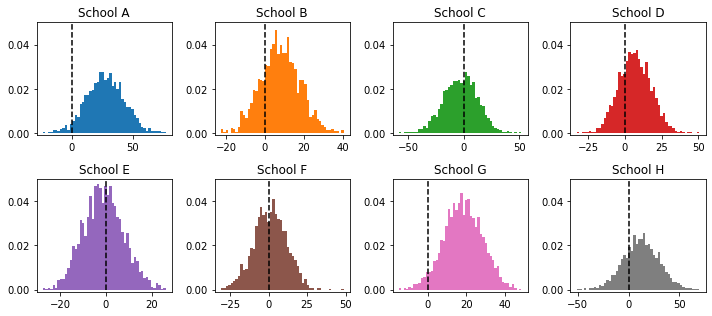

In [9]:
plt.figure(figsize=(10, 4.5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot([0,0], [0, 0.05], 'k--');
    plt.hist(separate_fit['theta'][:,i], density=True, color='C%d'%i, bins=50);
    plt.title("School "+schools[i]);
    plt.ylim(-0.001, 0.05);
plt.tight_layout();

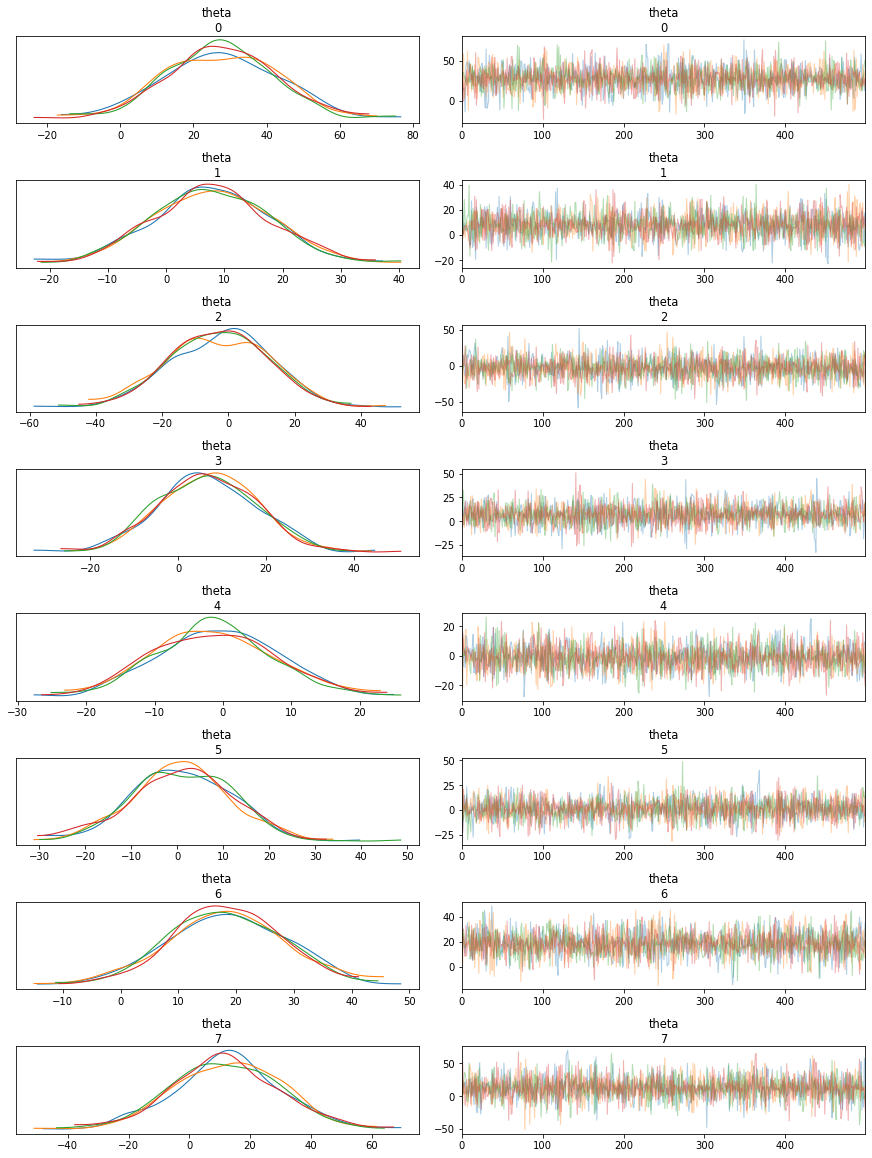

In [10]:
az.plot_trace(separate_fit, var_names=["theta"]);

In [11]:
print("Pr(school A effect > school C effect) = %0.3f" % separate_fit['A_gt_C'].mean(0));

Pr(school A effect > school C effect) = 0.924


## Partial pooling through a hierarchical model

Neither of these two interpretations is completely satisfactory:

1. It looks like coaching is generally helpful
2. There might be significant variation in how effective it is in different individual schools, for many reasons (including, e.g., the instructor and format of the course)

Can we tease out both these factors? We will consider a model that has per-school estimates $\theta_i$, like the separate model, but still has an overall mean treatment effect estimate $\mu$. We can do this by defining a model

$$\begin{align*}
\theta_i | \mu, \tau &\sim \mathcal{N}(\mu, \tau^2) \\
y_i | \theta_i, \sigma_i &\sim \mathcal{N}(\theta_i, \sigma_i^2).
\end{align*}$$

The parameter $\tau$ estimates how much variation there is between coaching programs in different schools.

The parameter $\sigma_i$ estimates how much variation there is for a coaching program within school $i$.



In [12]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    real theta[J];
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
generated quantities {
    int<lower=0,upper=1> is_positive;
    int<lower=0,upper=1> A_gt_C;

    is_positive = mu > 0;
    A_gt_C = theta[1] > theta[3];
}
"""
sm = pystan.StanModel(model_code=schools_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0f786a89dd4c4df25e749b2b053d6ce NOW.
/Users/brooks/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/p5/l7hjjt052zzf95mb4qqnb6nw0000gn/T/tmptgyw4ve_/stanfit4anon_model_b0f786a89dd4c4df25e749b2b053d6ce_7540468552209563691.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [13]:
fit = sm.sampling(data=schools_data, iter=1000, chains=4)
print(fit)

Inference for Stan model: anon_model_b0f786a89dd4c4df25e749b2b053d6ce.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu            7.81    0.34   4.84  -1.01   4.56    7.6  11.31  17.39    202   1.02
tau           6.64    0.51   5.45   1.17   2.71   5.05   9.04  20.04    116   1.02
theta[1]     11.18    0.42   7.95  -1.03   5.86   10.5  15.15  30.11    361   1.01
theta[2]      7.83    0.32   6.46  -5.37   3.79   7.66  12.03  21.36    405   1.01
theta[3]      6.26    0.34    7.6  -11.2   2.58   6.62  11.08  20.89    503   1.01
theta[4]      7.59    0.39   6.49  -5.67   3.49   7.39  12.08  20.39    273   1.02
theta[5]      5.14    0.42   6.23  -8.94   1.61   5.37   9.35  16.24    219   1.01
theta[6]      6.12     0.3   6.44  -7.96   2.33   6.44  10.43  18.34    475   1.01
theta[7]      10.6    0.39   6.53   0.01   6.01  10.07  14.27  25.

### Let's try to interpret these results.

We'll plot $\tau$, $\mu$, and $\theta$, and look at our generated quantities.

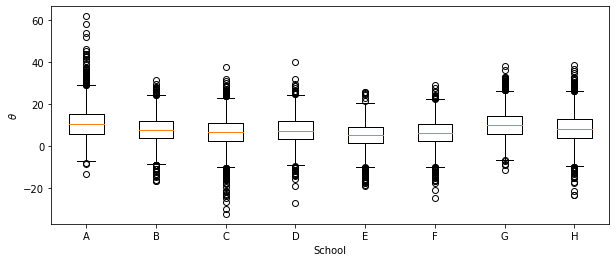

In [14]:
plt.figure(figsize=(10,4))
plt.boxplot(fit["theta"]);
plt.xticks(ticks=np.arange(1,9), labels=schools);
plt.ylabel("$\\theta$")
plt.xlabel("School");

Estimated Pr(mu > 0): 0.959
Estimated Pr(school A effect > school C effect): 0.667


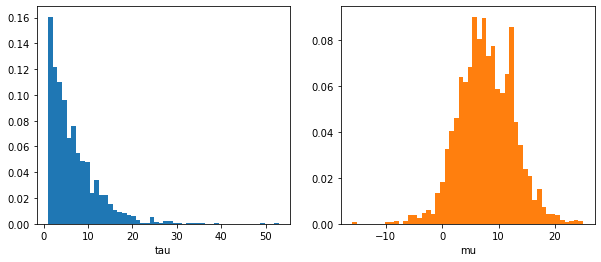

In [15]:
print("Estimated Pr(mu > 0): %0.3f" % fit['is_positive'].mean(0))
print("Estimated Pr(school A effect > school C effect): %0.3f" % fit['A_gt_C'].mean(0))
 
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(fit['tau'], bins=50, density=True);
plt.xlabel("tau");
plt.subplot(122)
plt.hist(fit['mu'], bins=50, density=True, color='C1');
plt.xlabel("mu");

We can also look at how the mean per-school estimates change as a function of $\tau$.

As $\tau \rightarrow 0$, we recover the pooled estimate; as $\tau \rightarrow \infty$, it resembles the individual estimates.

Note that from our posterior estimate, high-probability values of $\tau$ are from around 2-ish to around 12-ish. This represents significant "shrinkage" from the separate estimates, but does not shrink the whole way down to the single pooled estimate.

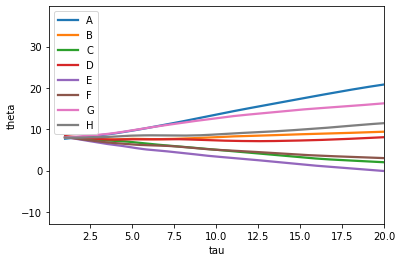

In [16]:
for i in range(8):
    sns.regplot(x=fit['tau'], y=fit['theta'][:,i], 
                lowess=True, scatter=False, color='C%d'%i)
plt.legend(schools, loc='upper left');
plt.xlim(0.05, 20)
plt.xlabel('tau')
plt.ylabel('theta');